Recurrent spillover branching process (infinite population), plots probabilities of outbreak (??)

TO DO: clarify what probability of outbreak even means here. 
In the code, extinction means a time when nobody is infected. Outbreak is when number of infecteds hits a threshold. Probability of outbreak means probability of hitting the latter before the former. Is this a sensible notion for this context??

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sim import sim

In [3]:
################################################
# simulates infection WITH recurrent spillover 
#
# this implementation is in "generation order" since it calls on the function sim.
# furthermore, each entire spillover tree is simulated before moving on to the next tree.
# for a "time order" implementation, see recurrent_sim_class.
#
################################################
#
# input alpha = spillover rate.
#
# inputs beta_0, gamma_0, mu_1, mu_2 are the same as in the function sim from above
#
# there are two hidden inputs max_t_ext, t_s, which you should ignore. (do NOT pass in any values for these.)
# they are only used implicitly when this function recursively calls itself.
#
################################################
#
# returns 1 if outbreak
# returns 0 if extinction
#
################################################
#
# TO DO: when alpha > 0, there may be the possibility of endemicity. 
# Right now, this function only terminates at outbreak or extinction. Need to fix this in the future.
# See recurrent_sim_class for an implementation which terminates after a certain maximum simulated number of days.
#
################################################

def recurrent_sim(alpha, beta_0, gamma_0, mu_1=0, mu_2=0, max_t_ext=0, t_s=0): 
    
    # hidden input max_t_ext keeps track of maximum extinction time seen so far
    # hidden input t_s keeps track of most recent time of spillover
    
    # simulate tree from a new spillover event
    sim_output = sim(beta_0, gamma_0, mu_1, mu_2)

    # if it outbreaks, we are done
    if sim_output == 1:
        
        #print("\n", "outbreak!")
        return 1
    
    # otherwise, that tree goes extinct
    # but we need to check whether any other spillovers happened in the meantime
    else:
        
        #print("max_t_ext updating, = max of ", max_t_ext, "and", sim_output[1])
        max_t_ext = max(max_t_ext, sim_output[1]) #update max extinction time, if necessary
        
       #if alpha is 0, no more spillovers ever occur. we are done.
        if alpha == 0: 
            return 0
        
        #otherwise, generate time of next spillover
        dt_s = np.random.exponential(scale=1/alpha) #inter-spillover time
        t_s += dt_s #time of next spillover
        #print("time of spillover is t_s = ", t_s)

        # if spillover occurs soon enough, we have to simulate another tree. recurse.
        if t_s < max_t_ext: 
            
            #print("a spillover occured! Recursing...")
            return recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2, max_t_ext, t_s)

        # if spillover occurs too late, we are done.
        else: 
            
            #print("next spillover too late. extinction!")
            return 0

In [4]:
##################################################
# runs many simulations WITH recurrent spillover #
##################################################
#
# returns the percentage of them that outbreak
#
##################################################

def recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1 = 0, mu_2 = 0, N_sims=100): 
    N_outbreaks = 0
    for i in range(N_sims):
        if recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2) == 1: 
                N_outbreaks += 1
    return N_outbreaks/N_sims

In [5]:
# run a single simulation

#parameters
alpha = 0.1
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim(alpha, beta_0, gamma_0)

0

In [6]:
%%time
# run a bulk simulation

#parameters
alpha = 0.01
beta_0 = 0.09
gamma_0 = 0.01
mu_1=0.001
mu_1=0.001

recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1, mu_1, N_sims=1000)

CPU times: user 2.2 s, sys: 28.1 ms, total: 2.22 s
Wall time: 2.74 s


0.899

In [7]:
###########################################################################
# for a fixed mu and alpha, plots the probability of outbreak against R_0 #
###########################################################################
#
# input alpha
# input mu = mu_1 = mu_2
#
# optional inputs R0_min, R0_max give range of R_0 to plot over.
# optional input N_points gives number of points to plot.
# optional inputs N_sims gives number of simulations to run per point.
#
##########################################################################

def recurrent_prob_plot(alpha, mu, R0_min=0.001, R0_max=2.5, N_points = 75, N_sims=750):
    
    # Take some evenly spaced R_0 values
    # Note that it does matter what beta and gamma are, even if they give the same R_0. 
    # But here we're just fixing gamma to be 0.1
    # TO DO later: explore other choices.
    beta_range = np.linspace(R0_min/10, R0_max/10, N_points); gamma = 0.1
    
    # initialize arrays to be plotted
    R0 = []; percent = []

    #simulate percentages of outbreak
    for beta in beta_range:
        R0 = np.append(R0, beta/gamma)
        percent = np.append(percent, recurrent_sim_percentage(alpha, beta, gamma, mu, mu, N_sims))
        
    #make the plot
    plt.plot(R0, percent, "ob")
    #graph the actual probability of outbreak with no mutation and no recurrent spillover
    #####################################################################################
    # From Linda's talk:
    #                            0 if R_0 < 1
    #                            1-1/R_0 = 1-gamma/beta if R_0 > 1
    #####################################################################################
    plt.plot(R0, np.piecewise(R0, [R0<1, R0>=1], [0, lambda R0: 1-1/R0]), "r", label='probability without mutation')
    plt.title('alpha = {}, mu1 = mu2 = {}'.format(alpha, mu))
    plt.xlabel("R_0"); plt.ylabel("p")
    plt.xlim(R0_min, R0_max)
    plt.legend()
    plt.show()

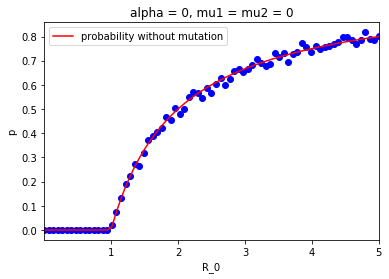

CPU times: user 1min 53s, sys: 958 ms, total: 1min 54s
Wall time: 1min 58s


In [9]:
%%time 

#########################
# SANITY CHECK 2 
# When there is no mutation, and no spillover, check that our simulation agrees with known results.
#########################

recurrent_prob_plot(alpha=0, mu=0, R0_max=5)

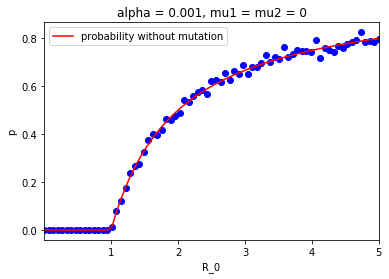

CPU times: user 2min 6s, sys: 2.36 s, total: 2min 9s
Wall time: 2min 10s


In [10]:
%%time
recurrent_prob_plot(alpha=0.001, mu=0, R0_max=5)

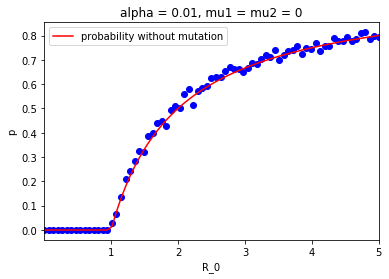

CPU times: user 2min 1s, sys: 1.43 s, total: 2min 2s
Wall time: 2min 3s


In [11]:
%%time
recurrent_prob_plot(alpha=0.01, mu=0, R0_max=5)

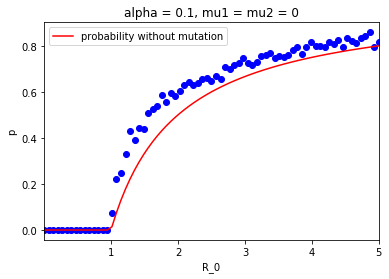

CPU times: user 2min 14s, sys: 760 ms, total: 2min 15s
Wall time: 2min 15s


In [12]:
%%time
recurrent_prob_plot(alpha=0.1, mu=0, R0_max=5)

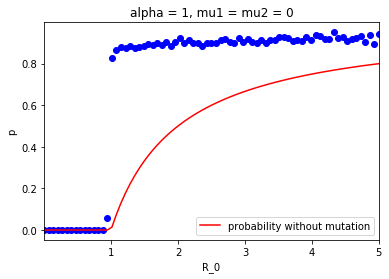

CPU times: user 6min 59s, sys: 3.76 s, total: 7min 3s
Wall time: 11min 46s


In [13]:
%%time
recurrent_prob_plot(alpha=1, mu=0, R0_max=5)